# Networks and their Structure Assignment

## Network Science Topic 2

Note that the networks in this exercise are undirected.

This exercise concerns the **Kleinberg model** which we claimed was an example of a *searchable* network.

A **Kleinberg graph** is defined by four parameters $n$, $m$, $p$ and $\alpha$.  It is constructed as follows:
* The graph has $n$ nodes. We think of these as being arranged on a circle.
* Each node is joined to the nearest $m$ nodes on either side (so it has $2m$ neighbours in total).
* Then each node $v$ is considered, and each of the original edges going to a clockwise neighbour is considered in turn. With rewiring probability $p$ the edge is deleted and replaced with an edge from $v$ to a vertex $w$ chosen at random: but vertices are not equally likely to be chosen as $w$. The vertex $w$ is chosen with probability proportional to $d_w^{-\alpha}$ where $d_w$ is the shorter distance around the circle from v to w. (Note that if the edge from $v$ to $w$ already exists then the original edge is not deleted and no action is taken).

Write code to construct an instance of the Kleinberg model.  Here is how you might find the probability distribution needed to choose the random vertex $w$ in the third step above.
* Once you have decided to rewire an edge from $v$, for every other vertex $w$, find $d_w^{-\alpha}$. Put these values in a list.
* Find the sum $S$ of the values in the list. So the probability of rewiring from $v$ to $w$ is $d_w^{-\alpha}/S$.
* Find a random real number $R$ between 0 and $S$, and initiate a variable *total* with value 0.
* Go through the list, add each number to *total*. Stop when *total* is more than $R$. The vertex that corresponds to the point reached in the list is $w$.

In [1]:
import random
import itertools
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%run NatSfunctions.ipynb

In [2]:
# delete the current edge and replace with edge to another vertex
def rewire(v, neighbour, n, a, graph):
    
    distances = []
    
    # find the shorter distance from v to every other vertex raised to power -a
    for vertex in graph:

        # compute distances in both directions; take minimum and raise to -a
        distance1 = abs(vertex - v)
        distance2 = (distance1 * -1) % n

        a_distance = min(distance1, distance2)
        
        if a_distance != 0:
            a_distance = a_distance ** -a

        distances.append(a_distance)
    
    # compute probability
    S = sum(distances)
    random_number = random.uniform(0, S)
    total = 0
    
    # go through list and add each number to total
    for i in range(0, len(distances)):
        
        total += distances[i]
        if total > random_number:
            w = i  # vertex corresponding to this point is the one rewired to
            break
    
    # if edge from v to w already exists do nothing
    # otherwise remove the old edge and add the rewired one
    if w not in graph[v]:
        graph[v].append(w)
        graph[v].remove(neighbour)

    return graph

In [3]:
def create_Kleinberg_graph(n, m, p, a):

    graph = {}

    # connect initial vertices to m nearest neighbours on either side
    for vertex in range(0, n):

        # get the neighbours ahead and behind current vertex
        clockwise_neighbours = [neighbour % n for neighbour in range(vertex + 1, vertex + m + 1)]
        anticlockwise_neighbours = [neighbour % n for neighbour in range(vertex - 1, vertex - m - 1, -1)]

        # combine and assign to vertex
        neighbours = clockwise_neighbours + anticlockwise_neighbours
        graph[vertex] = neighbours


    # consider each node
    for vertex in graph:
        
        # consider each edge going to a clockwise neighbour
        clockwise_neighbours = graph[vertex][:m]
        
        for neighbour in clockwise_neighbours:
            
            # rewire with rewiring probability p
            random_number = random.random()
            if random_number < p:
                rewired_graph = rewire(vertex, neighbour, n, a, graph)
    
    return graph

Write a function to find the *search time* of a graph. This is the number of steps needed to get from a vertex $v$ to a vertex $w$ when, at each step, you traverse the edge that will bring you to the position on the circle closest to $w$. In fact, the search time is the average over all pairs of vertices, but if this is too slow to compute it should be possible to approximate by look at a random sample of pairs.

In [49]:
# returns number of steps needed to get from v to w
# when traversing at each step the edge whose endpoint is closest to w on the circle
def get_steps(v, w, m, graph):
    
    # initialise steps and neighbours
    steps = 0
    n = len(graph)
    distance = n - abs(v - w)
    
    while True:

        neighbours = graph[v]

        # if w is a neighbour then steps is 1
        if w in neighbours:
            steps += 1
            break

        # otherwise find closest neighbour to w and keep going
        if distance > n // 2:
            v = min(neighbours, key=lambda x: abs(x - w))
        else:
            if v < m:
                v = n - m + v
            else:
                v -= m

        steps += 1

    return steps

In [50]:
# average number of steps between all pairs of vertices
def get_search_time(graph, m, pairings):

    steps_list = []
    vertex_combinations = list(itertools.combinations(graph, 2))
    random_vertex_pairs = random.sample(vertex_combinations, pairings)

    for v, w in random_vertex_pairs:
        steps = get_steps(v, w, m, graph)
        steps_list.append(steps)
    
    average_steps = sum(steps_list)/len(steps_list)
    return average_steps

1. [15 marks] Plot search time versus $\alpha$ for Kleinberg graphs with $m=8$, $p=0.05$ for the following values of $n$: 1000, 2000, 3000, 4000.

In [57]:
m = 8
p = 0.05
n_values = [1000, 2000, 3000, 4000]
a_values = np.arange(0, 5.1, 0.5)

search_times = [[], [], [], []]

for index in range(0, len(n_values)):

    n = n_values[index]
    
    for a in a_values:

        K_graph = create_Kleinberg_graph(n, m, p, a)
        search_time = get_search_time(K_graph, m, pairings=100)
        search_times[index].append(search_time)
        
    print(n)

1000
2000
3000
4000


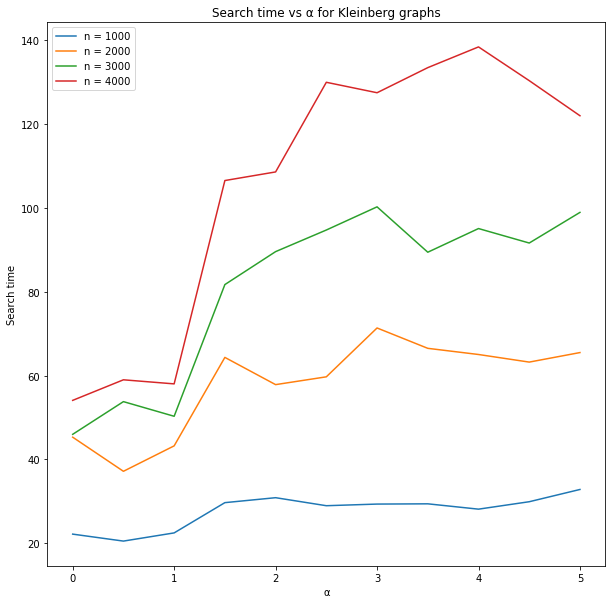

In [58]:
y1k = search_times[0]
y2k = search_times[1]
y3k = search_times[2]
y4k = search_times[3]

plt.plot(a_values, y1k, label='n = 1000')
plt.plot(a_values, y2k, label='n = 2000')
plt.plot(a_values, y3k, label='n = 3000')
plt.plot(a_values, y4k, label='n = 4000')
plt.title('Search time vs \u03B1 for Kleinberg graphs')
plt.xlabel('\u03B1')
plt.ylabel('Search time')
plt.legend()
plt.rcParams["figure.figsize"] = (10, 10)

2. [5 marks] Plot the relationship between the number of nodes and search time (for fixed $m$, $p$ and $\alpha$).

In [60]:
a = 3
search_times = []
n_values = [n for n in range(100, 5001, 25)]

for n in n_values:
    
    K_graph = create_Kleinberg_graph(n, m, p, a)
    search_time = get_search_time(K_graph, m, pairings=100)
    search_times.append(search_time)

    if n % 1000 == 0:
        print(n)

1000
2000
3000
4000
5000


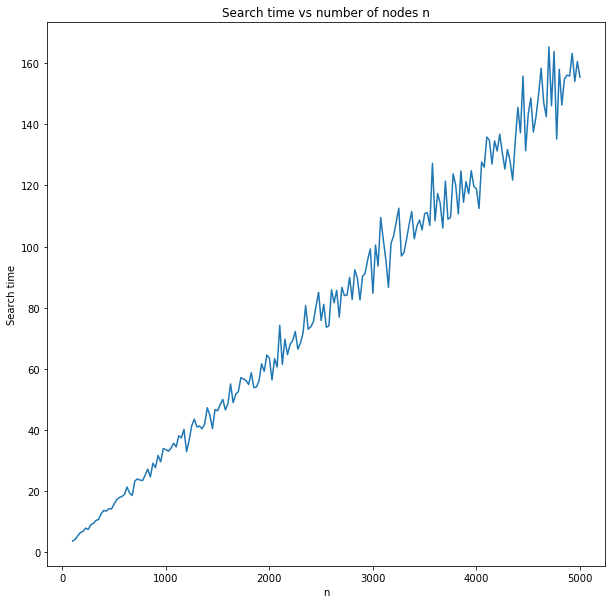

In [61]:
plt.plot(n_values, search_times)
plt.title('Search time vs number of nodes n')
plt.xlabel('n')
plt.ylabel('Search time')
plt.rcParams["figure.figsize"] = (10, 10)

You will need to submit all code and plots for this question.  You can do this most simply by extending this notebook, but you can also, for example, submit py and image files.  You will be given detailed instructions on the submission for this module before the deadline next term.